In [1]:
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F

import random

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# globals
STATE_SHAPE = (210, 160, 3)
ACTION_SIZE = 14
BATCH_SIZE = 32

In [3]:
def get_action_dqn(network, state, epsilon, epsilon_decay):
    """Select action according to e-greedy policy and decay epsilon

    Args:
        network (QNetwork): Q-Network
        state (np-array): current state, size (state_size)
        epsilon (float): probability of choosing a random action
        epsilon_decay (float): amount by which to decay epsilon

    Returns:
        action (int): chosen action [0, action_size)
        epsilon (float): decayed epsilon
    """ 
    if random.uniform(0,1) > epsilon:
        x = torch.cuda.FloatTensor(state).unsqueeze(0)
        qs = network(x)
        values, indices = qs.squeeze().max(0)
        choice = indices.item()
    else:
        # in this case, choose randomly
        choice = random.randint(0,ACTION_SIZE-1)

    epsilon *= epsilon_decay
    return choice, epsilon


def prepare_batch(memory, batch_size):
    """Randomly sample batch from memory
     Prepare cuda tensors

    Args:
        memory (list): state, action, next_state, reward, done tuples
        batch_size (int): amount of memory to sample into a batch

    Returns:
        state (tensor): float cuda tensor of size (batch_size x state_size()
        action (tensor): long tensor of size (batch_size)
        next_state (tensor): float cuda tensor of size (batch_size x state_size)
        reward (tensor): float cuda tensor of size (batch_size)
        done (tensor): float cuda tensor of size (batch_size)
    """
    batch = random.sample(memory, batch_size)
    state = torch.tensor([t[0] for t in batch])
    action = torch.tensor([t[1] for t in batch])
    next_state = torch.tensor([t[2] for t in batch])
    reward = torch.tensor([t[3] for t in batch])
    done = torch.tensor([t[4] for t in batch])

    return state.float().cuda(), action.long().cuda(), next_state.float().cuda(), reward.float().cuda(), done.float().cuda()


def learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update):
    """Update Q-Network according to DQN Loss function
     Update Target Network every target_update global steps

    Args:
        batch (tuple): tuple of state, action, next_state, reward, and done tensors
        optim (Adam): Q-Network optimizer
        q_network (QNetwork): Q-Network
        target_network (QNetwork): Target Q-Network
        gamma (float): discount factor
        global_step (int): total steps taken in environment
        target_update (int): frequency of target network update
    """
    optim.zero_grad()

    state, action, next_state, reward, done = batch

    q_actions = q_network.forward(torch.cuda.FloatTensor(state).cuda())
    target_actions = target_network.forward(torch.cuda.FloatTensor(next_state))

    # Get the q-values for the chosen actions
    q_sa_list = [q_actions[i][a] for i,a in enumerate(list(action))]
    q_sa = q_sa_list[0].unsqueeze(0)
    for i in range(1,BATCH_SIZE):
        q_sa = torch.cat((q_sa,q_sa_list[i].unsqueeze(0)))

    target_actions, _ = target_actions.max(1)
    qstar_sa = target_actions
    ans = (q_sa - (reward + gamma *qstar_sa*(1-done.int()))) ** 2

    loss = torch.sum(ans)
    loss.backward()

    optim.step()

    if global_step % target_update == 0:
        target_network.load_state_dict(q_network.state_dict())

    return loss.item()

In [4]:
# Q-Value Network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        hidden_size = 8
        c,h,w = state_size
        self.net1 = nn.Sequential(nn.Conv2d(c,64,(3,3),padding=(1,1)),
                                    nn.Conv1d(64,64,(3,3),padding=(1,1)),
                                    nn.MaxPool2d((3, 3), stride=(2, 2), padding = (1,1), dilation = (1,1)),
                                    nn.Conv2d(64,128,(3,3),padding=(1,1)),
                                    nn.Conv2d(128,128,(3,3),padding=(1,1)),
                                    nn.MaxPool2d((3, 3), stride=(2, 2), padding = (1,1), dilation = (1,1)))
        
        self.net2 = nn.Sequential(nn.Linear(5120, hidden_size),
                            nn.ReLU(),
                            nn.Linear(hidden_size, hidden_size),
                            nn.ReLU(),
                            nn.Linear(hidden_size, hidden_size),
                            nn.ReLU(),
                            nn.Linear(hidden_size, ACTION_SIZE))  

    def forward(self, x):
        """Estimate q-values given state

          Args:
              state (tensor): current state, size (batch x state_size)

          Returns:
              q-values (tensor): estimated q-values, size (batch x action_size)
        """
        a = self.net1(x)
        b = a.view(-1, 128*40)
        return self.net2(b)

In [5]:
# import drive to save the model to my drive
from google.colab import drive
drive.mount('drive')
MODEL_PATH = 'drive/My Drive/CS 470/final-project/asteroids-model.pt'

Mounted at drive


In [6]:
# Load the Model
q_network = torch.load(MODEL_PATH)

In [7]:
# Hyper parameters
lr = 1e-2
epochs = 1000
start_training = 4000
gamma = 0.99
batch_size = 32
epsilon = 1
epsilon_decay = .9999
target_update = 1000
learn_frequency = 2
max_reward = 40000

# Init environment
env = gym.make('Asteroids-v0', )

# Init networks
target_network = QNetwork(STATE_SHAPE, ACTION_SIZE).cuda()
target_network.load_state_dict(q_network.state_dict())

# Init optimizer
optim = torch.optim.Adam(q_network.parameters(), lr=lr)

# Init replay buffer
memory = []

# Begin main loop
results_dqn = []
global_step = 0
loop = tqdm(total=epochs, position=0, leave=False)
loss = 0
losses = []

for epoch in range(epochs):

    # Reset environment
    state = env.reset()
    done = False
    cum_reward = 0  # Track cumulative reward per episode

    # Begin episode
    # TODO - I need to change this reward to match the reward of Asteroids
    while not done and cum_reward < max_reward:  # End after max_reward is reached 
        # Select e-greedy action
        action, epsilon = get_action_dqn(q_network, state, epsilon, epsilon_decay)

        # Take step
        next_state, reward, done, _ = env.step(action)
        
        # env.render()

        # Store step in replay buffer
        memory.append((state, action, next_state, reward, done))

        cum_reward += reward
        global_step += 1  # Increment total steps
        state = next_state  # Set current state

        # If time to train
        if global_step > start_training and global_step % learn_frequency == 0:

            # Sample batch
            batch = prepare_batch(memory, batch_size)

            # Train
            loss = learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update)
            
    # Print results at end of episode
    results_dqn.append(cum_reward)
    loop.update(1)
    loop.set_description('Episodes: {} Reward: {} Loss: {}'.format(epoch, cum_reward, loss))
    
    # Save the Model 
    torch.save(q_network,MODEL_PATH)
    losses.append(loss)


Episodes: 2 Reward: 580.0 Loss: 50.51006317138672:   0%|          | 3/1000 [26:06<110:29:06, 398.94s/it] 

KeyboardInterrupt: ignored

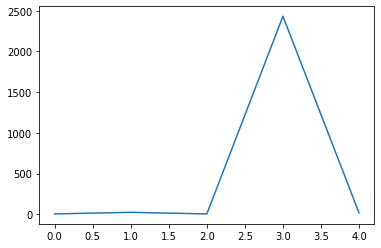

In [ ]:
plt.plot(losses)
plt.show()